# Kalman-Filter implementation 

In [370]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import multivariate_normal
from matplotlib.lines import Line2D

In [371]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

custom_lines = [
    Line2D([0], [0], color="tab:blue", lw=2),
    Line2D([0], [0], color="tab:orange", lw=2)
]

In [372]:
def lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T):
    """
    Simulation of a continous-time Kalman-Bucy filter using
    the Euler–Maruyama method
    """
    # Sample initial condition
    N0 = multivariate_normal(μ0, V0)
    z0 = N0.rvs()
    
    # Initial variables
    dt = T / n_steps
    m, *_ = z0.shape
    zeros = np.zeros((m, m))
    M = np.r_[np.c_[A, zeros],
              np.c_[zeros, C @ A]]
    cov = np.r_[np.c_[Γ, zeros],
                np.c_[zeros, Σ]]
    W = multivariate_normal(cov=cov)
    vn = np.concatenate((z0, z0))    
    sol = np.zeros((2 * m, n_sims, n_steps))
    
    vn = np.concatenate((z0, z0))[..., None] * np.ones((2 * m, n_sims))
    sol[:, :, 0] = vn
    for n in range(1, n_steps):
        dW = W.rvs(n_sims).T
        # vn + M * v + dW
        vn = np.concatenate((vn[:2], vn[:2])) * np.ones((2 * m, n_sims))
        vn = vn + np.einsum("ij,js->is", M, vn) * dt + dW * np.sqrt(dt)
        sol[:, :, n] = vn
    return sol

In [373]:
μ0 = np.array([0, 0])
V0 = np.array([[1, 0], [0, 1]]) / 1000

A = np.array([
    [0, 0.5],
    [-0.1, 0]
]) / 2

C = np.array([
    [1, 0.],
    [0.0, 1]
]) 

# Γ = np.array([
#     [0.4,  -0.1],
#     [-0.1, 0.5]
# ])
# Γ = Γ @ Γ.T / 5


# high-variance configuration
Γ = np.eye(2) * 1.5
Σ = np.eye(2) * 5

# low-variance configuration
Γ = np.eye(2) / 110
Σ = np.eye(2) / 110

muv = np.zeros(4)
zeros = np.zeros((2, 2))

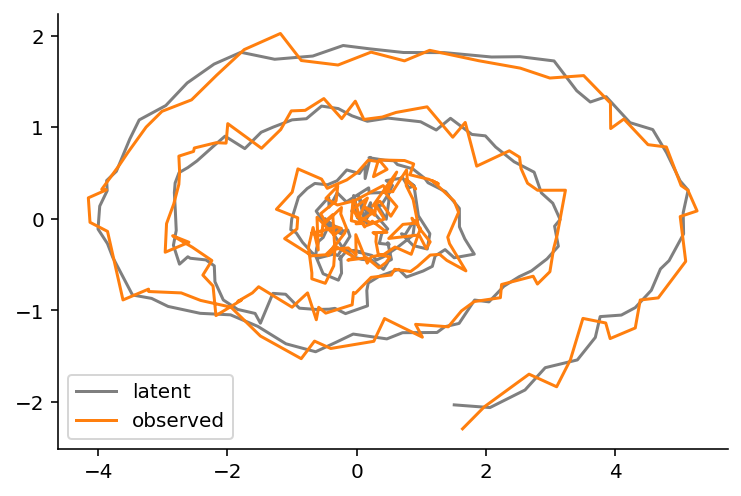

In [375]:
np.random.seed(314)
n_sims, n_steps = 2, 250
T = 250
sol = lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T)

for n in range(1, n_sims):
    plt.plot(sol[0, n, :], sol[1, n, :], c="tab:gray", alpha=1, label="latent")
    plt.plot(sol[2, n, :], sol[3, n, :], c="tab:orange", alpha=1, label="observed")
plt.legend()

## Part 2

In [411]:
Δ = 0.1
A = np.array([
    [1, 0, Δ, 0],
    [0, 1, 0, Δ],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
])


Γ = np.eye(4) * 0.001
Σ = np.eye(2) * 1.0

μ0 = np.array([8, 10, 1, 0])
V0 = np.eye(4) * 1.0

n_sims, n_steps = 3, 10
T = 15

### The goal: Recover the following parameters using a Kalman-Filter

In [412]:
def lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T):
    """
    Simulation of a continous-time Kalman-Bucy filter using
    the Euler–Maruyama method
    """
    dt = T / n_steps
    # Sample initial condition
    N0 = multivariate_normal(μ0, V0)
    z0 = N0.rvs(n_sims)
    
    m_latent, _ = A.shape
    m_obs, _ = C.shape
    
    latent_rvs = multivariate_normal(cov=Γ).rvs((n_sims, n_steps))
    obs_rvs = multivariate_normal(cov=Σ).rvs((n_sims, n_steps))
    
    sol_latent = np.zeros((n_sims, n_steps, m_latent))
    sol_obs = np.zeros((n_sims, n_steps, m_obs))
    
    sol_latent[:, 0, :] = z0
    sol_obs[:, 0, :] = np.einsum("ij,sj->si", C, z0)
    
    zn = z0
    xn = np.einsum("ij,sj->si", C, z0)
    
    sol_latent[:, 0, :] = zn
    sol_obs[:, 0, :] = xn
    for n in range(1, n_steps):
        ϵn = latent_rvs[:, n, :]
        φn = obs_rvs[:, n, :]
        
        z_new = zn + np.einsum("ij,sj->si", A, zn) * dt + ϵn * np.sqrt(dt)
        xn = zn + np.einsum("ij,sj->si", C @ A, zn) * dt + φn * np.sqrt(dt)
        zn = z_new
        
        sol_latent[:, n, :] = zn
        sol_obs[:, n, :] = xn
        
    return sol_latent, sol_obs

In [414]:
μ0 = np.array([0, 0])
V0 = np.array([[1, 0], [0, 1]]) / 1000

A = np.array([
    [0, 0.5],
    [-0.1, 0]
]) / 2

C = np.array([
    [1, 0.0],
    [0.0, 1]
]) 

# Γ = np.array([
#     [0.4,  -0.1],
#     [-0.1, 0.5]
# ])
# Γ = Γ @ Γ.T / 5


# high-variance configuration
Γ = np.eye(2) * 1.5
Σ = np.eye(2) * 5

# low-variance configuration
Γ = np.eye(2) / 110
Σ = np.eye(2) / 110

muv = np.zeros(4)
zeros = np.zeros((2, 2))

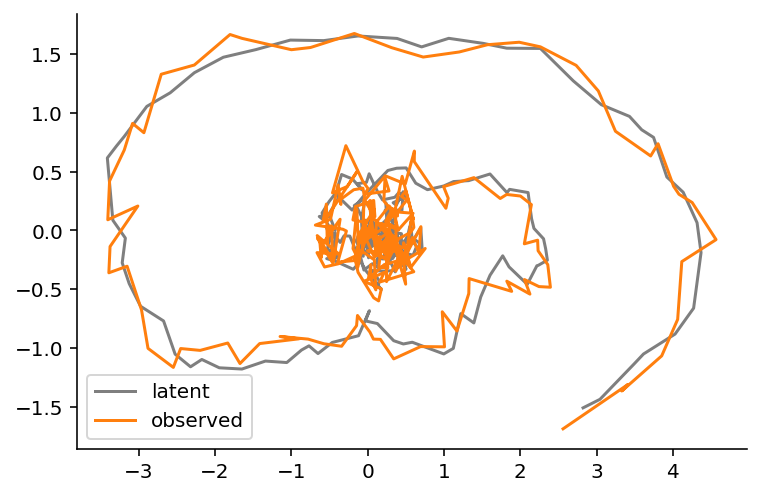

In [415]:

n_sims, n_steps = 5, 250
T = 250
latent, obs = lds_sample(μ0, V0, A, C, Γ, Σ, n_sims, n_steps, T)

plt.plot(*latent[2].T, label="latent", c="tab:gray")
plt.plot(*obs[2].T, label="observed", c="tab:orange")
plt.legend()

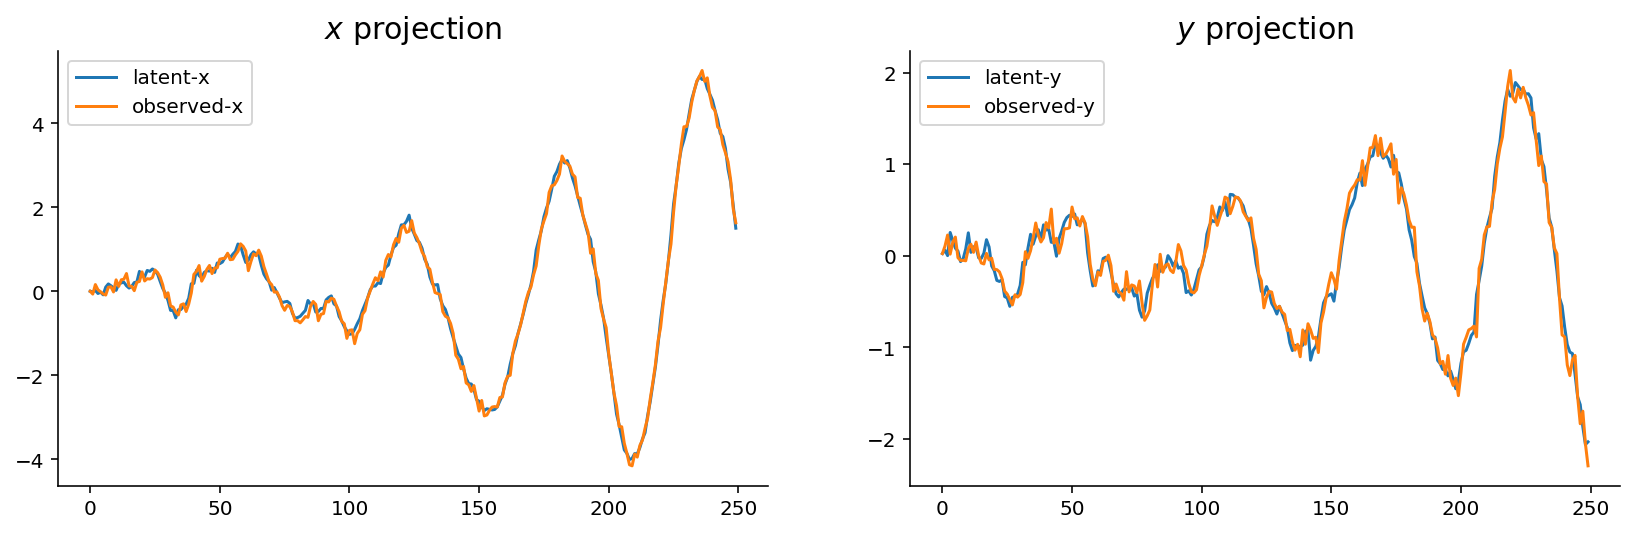

In [410]:
nsim = 1
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(sol[0, nsim, :], label="latent-x")
ax[0].plot(sol[2, nsim, :], label="observed-x")
ax[0].legend()
ax[0].set_title("$x$ projection", fontsize=15)

ax[1].plot(sol[1, nsim, :], label="latent-y")
ax[1].plot(sol[3, nsim, :], label="observed-y")
ax[1].legend()
ax[1].set_title("$y$ projection", fontsize=15);

## Step 1: Suppose the parameters are already known

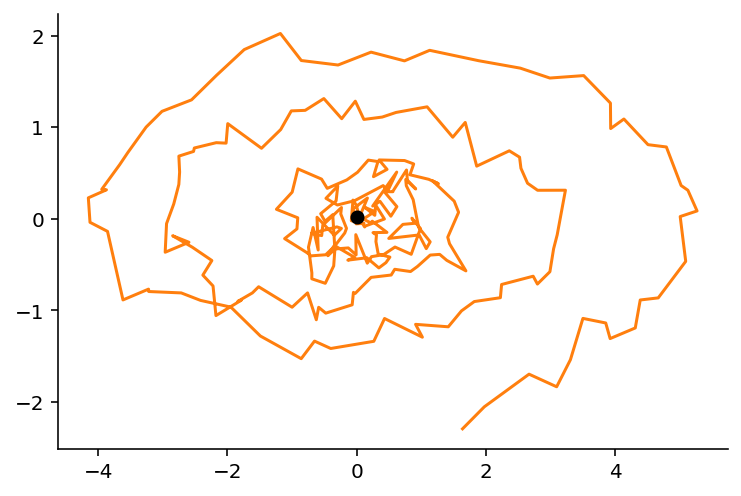

In [348]:
Z = sol[[0, 1], nsim].T
X = sol[[2, 3], nsim].T

plt.scatter(*X[0, :], c="black", zorder=2)
plt.plot(*X.T, c="tab:orange", zorder=1)

In [349]:
I = np.eye(2)
K1 = V0 @ C.T @ inv(C @ V0 @ C.T + Σ)

μ1 = μ0 + K1 @ (X[1] - C @ μ0)
V1 = (I - K1 @ C) @ V0

In [350]:
μ_hist = np.zeros((n_steps, 2))
μ_hist[0] = μ1

Vn = V1
for n in range(1, n_steps):
    Pnm1 = Γ + A @ Vn @ A.T
    Kn = Pnm1 @ C.T @ inv(C @ Pnm1 @ C.T + Σ)
    
    μn = A @ μ_hist[n-1] + Kn @ (X[n] - C @ A @ μ_hist[n-1])
    Vn = (I - Kn @ C) @ Pnm1
    μ_hist[n] = μn

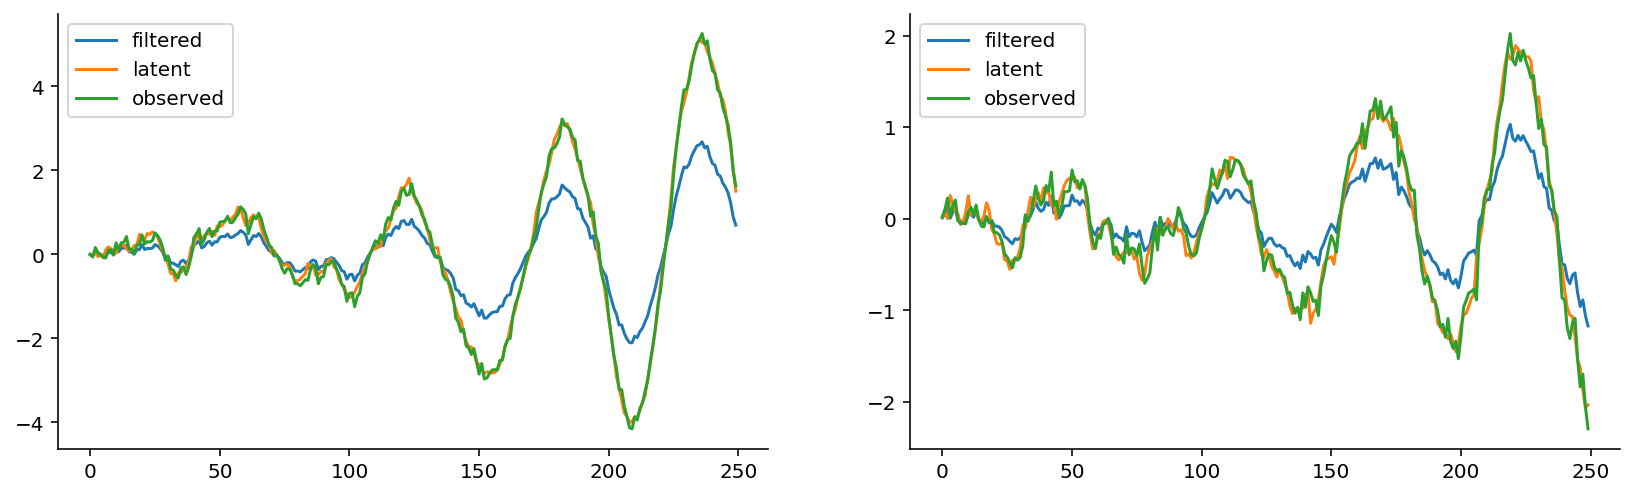

In [351]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(μ_hist[:, 0], label="filtered")
ax[0].plot(Z[:, 0], label="latent")
ax[0].plot(X[:, 0], label="observed")
ax[0].legend()

ax[1].plot(μ_hist[:, 1], label="filtered")
ax[1].plot(Z[:, 1], label="latent")
ax[1].plot(X[:, 1], label="observed")
ax[1].legend()

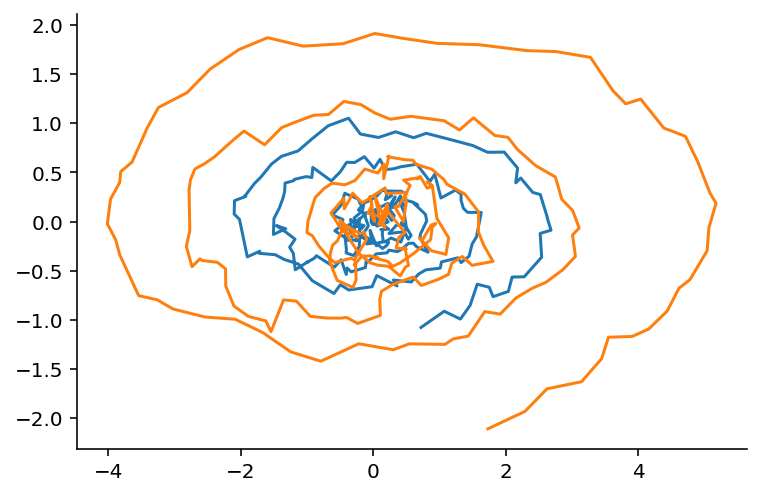

In [262]:
plt.plot(*μ_hist.T)
plt.plot(*Z.T)